In [0]:
!pip install gdown

In [0]:
!gdown https://drive.google.com/uc?id=12Uk6cECvvLJkS6SS4xJK3S_AxbsIAel1

In [0]:
!mkdir data
!mv train_meta.pkl data/

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import pickle
from sklearn.externals import joblib

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from datetime import timedelta

In [18]:
root_folder = "./data"
train_file = path.join(root_folder,"train_meta.pkl")
df = pd.read_pickle(train_file)
df.head()

,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,588.0,7.0,0.0,1.0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,589.0,7.0,0.0,1.0,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,643.0,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,683.0,7.0,0.0,1.0,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,699.0,7.0,0.0,1.0,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,12.0,11.0,7.0,9.0,6.0,10.0,8.0,13.0,3.0,14.0,4.0,9.0,14.0,10.0,8.0,3.0,74.0,17.0,8.0,6.0,9.0,3.0,10.0,21.0,9.0,5.0,...,41.0,35.0,18.0,18.0,15.0,16.0,13.0,14.0,29.0,18.0,28.0,21.0,10.0,19.0,13.0,8.0,54.0,19.0,14.0,41.0,32.0,46.0,31.0,29.0,31.0,28.0,17.0,16.0,8.0,13.0,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


In [19]:
meta = df.iloc[:,:4]
df = df.iloc[:,4:]
df.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,12.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,8.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,12.0,11.0,7.0,9.0,6.0,10.0,8.0,13.0,3.0,14.0,4.0,9.0,14.0,10.0,8.0,3.0,74.0,17.0,8.0,6.0,9.0,3.0,10.0,21.0,9.0,5.0,3.0,4.0,1.0,7.0,...,41.0,35.0,18.0,18.0,15.0,16.0,13.0,14.0,29.0,18.0,28.0,21.0,10.0,19.0,13.0,8.0,54.0,19.0,14.0,41.0,32.0,46.0,31.0,29.0,31.0,28.0,17.0,16.0,8.0,13.0,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


In [20]:
meta.head()

,name,lang,access,agent
0,588.0,7.0,0.0,1.0
1,589.0,7.0,0.0,1.0
2,643.0,7.0,0.0,1.0
3,683.0,7.0,0.0,1.0
4,699.0,7.0,0.0,1.0


In [21]:
data_start_date = df.columns[0]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2017-09-10


In [0]:
pred_steps = 60
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [0]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [24]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2017-05-13 00:00:00
Train prediction: 2017-05-14 00:00:00 - 2017-07-12 00:00:00 

Val encoding: 2015-08-30 00:00:00 - 2017-07-12 00:00:00
Val prediction: 2017-07-13 00:00:00 - 2017-09-10 00:00:00

Encoding interval: 683
Prediction interval: 60


In [0]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[0:]]),
                          data=[i for i in range(len(df.columns[0:]))])

series_array = df.values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array
  
def denormalizeSeries(series, means, sample_ind):
  new_series = series + means[sample_ind,0]
  new_series = np.expm1(new_series)
  return new_series

In [0]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(x)

model = Model(history_seq, pred_seq_train)

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          2080      
__________

In [28]:
first_n_samples = 40000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)


print(encoder_input_data.shape)
print(decoder_target_data.shape)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

(40000, 742, 1)
(40000, 60, 1)
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 23s 719us/step - loss: 0.3603 - val_loss: 0.3393
Epoch 2/10
32000/32000 [==============================] - 15s 458us/step - loss: 0.2700 - val_loss: 0.3299
Epoch 3/10
32000/32000 [==============================] - 15s 460us/step - loss: 0.2527 - val_loss: 0.3307
Epoch 4/10
32000/32000 [==============================] - 15s 460us/step - loss: 0.2482 - val_loss: 0.3286
Epoch 5/10
32000/32000 [==============================] - 15s 456us/step - loss: 0.2460 - val_loss: 0.3279
Epoch 6/10
32000/32000 [==============================] - 15s 455us/step - loss: 0.2449 - val_loss: 0.3279
Epoch 7/10
32000/32000 [==============================] - 15s 455us/step - loss: 0.2441 - val_loss: 0.3271
Epoch 8/10
32000/32000 [==============================] - 15s 457us/step - loss: 0.2437 - val_loss: 0.3278
Epoch 9/10
32000/32000 [==============================] - 15s 45

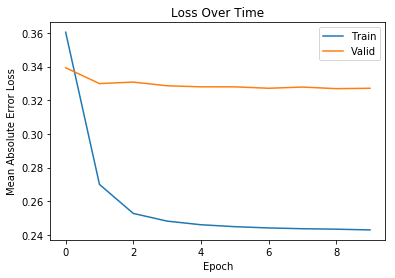

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [0]:
def predict_sequence(input_sequence, target_sequence, truth):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        if truth:
          last_step_pred =  target_sequence[i][0]
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [0]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [0]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind,means, enc_tail_len=50, truth=False):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1)     
    pred_series = predict_sequence(encode_series, target_series,truth)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   

    
    
    pred_series = denormalizeSeries(pred_series,means,sample_ind)
    encode_series = denormalizeSeries(encode_series,means,sample_ind)
    target_series = denormalizeSeries(target_series,means,sample_ind)
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

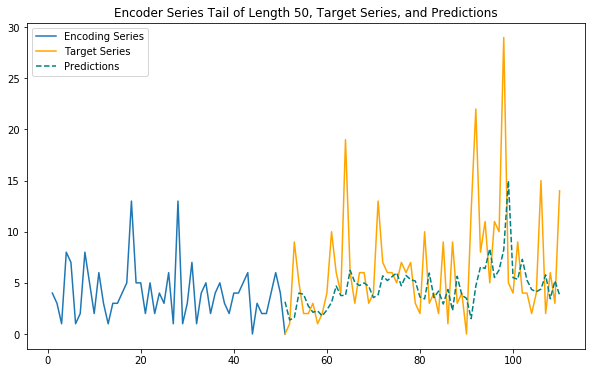

In [64]:
predict_and_plot(encoder_input_data, decoder_target_data, 100,encode_series_mean, enc_tail_len=50,truth=True)

In [0]:
def smape(A, F):
  return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [0]:
errors_truth = []
errors_standard = []
for sample_ind in np.random.choice(encoder_input_data.shape[0],100):
    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1)     
    pred_series_truth = predict_sequence(encode_series, target_series,True)
    pred_series_truth = pred_series_truth.reshape(-1,1)  
    
  
    pred_series_standard = predict_sequence(encode_series, target_series,False)
    pred_series_standard = pred_series_standard.reshape(-1,1)
    
    pred_series_standard = denormalizeSeries(pred_series_standard,encode_series_mean,i)
    pred_series_truth = denormalizeSeries(pred_series_truth,encode_series_mean,i)
    target_series = denormalizeSeries(target_series,encode_series_mean,i)
    
    errors_truth.append(smape(target_series,pred_series_truth))
    errors_standard.append(smape(target_series,pred_series_standard))

In [68]:
np.array(errors_truth).mean()

25.705179065034944

In [69]:
np.array(errors_standard).mean()

39.41652056208525